In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from config import *
%matplotlib inline

In [243]:
data = pd.read_csv(os.path.expanduser(PROCESSED_DATA_FOLDER+PROCESSED_FILE),
                   parse_dates=['check_date', 'departure_time'])

In [3]:
#data = data.sort_values('check_date')

In [244]:
data.head()

,Unnamed: 0,check_date,from,to,flight_date,departure_time,arrival_time,flight_number,price,price_gbp,timestamp_ms
0,1,2015-07-20 14:00:01.250,EDI,GDN,2015-10-20,2015-10-20 16:35:00,2015-10-20 19:55,FR7921,23.99,23.99,1.437401e+12
1,117,2015-07-20 14:00:01.250,STN,POZ,2015-10-16,2015-10-16 11:20:00,2015-10-16 14:25,FR2336,33.99,33.99,1.437401e+12
2,118,2015-07-20 14:00:01.250,STN,POZ,2015-10-17,2015-10-17 11:20:00,2015-10-17 14:25,FR2336,18.99,18.99,1.437401e+12
3,119,2015-07-20 14:00:01.250,STN,POZ,2015-10-18,2015-10-18 11:20:00,2015-10-18 14:25,FR2336,22.99,22.99,1.437401e+12
4,120,2015-07-20 14:00:01.250,STN,POZ,2015-10-19,2015-10-19 11:20:00,2015-10-19 14:25,FR2336,18.99,18.99,1.437401e+12


In [245]:
data['check_date'].describe()

count                           9003
unique                            57
top       2015-08-30 09:00:01.618000
freq                             180
first     2015-07-20 14:00:01.250000
last      2015-10-08 21:00:01.563000
Name: check_date, dtype: object

In [246]:
# TO DATETIME
data['departure_time'] = pd.to_datetime(data['departure_time'])

In [247]:
# EXPAND 
data['days_to_flight'] = data.apply(lambda x: (x['departure_time'] - x['check_date']).days, axis=1)

In [248]:
# ADD ID COLUMN
data['flight_id'] = data.apply(lambda x: ('{}-{}'.format(x['flight_number'], str(x['departure_time']))), axis=1)
data.head()

,Unnamed: 0,check_date,from,to,flight_date,departure_time,arrival_time,flight_number,price,price_gbp,timestamp_ms,days_to_flight,flight_id
0,1,2015-07-20 14:00:01.250,EDI,GDN,2015-10-20,2015-10-20 16:35:00,2015-10-20 19:55,FR7921,23.99,23.99,1.437401e+12,92,FR7921-2015-10-20 16:35:00
1,117,2015-07-20 14:00:01.250,STN,POZ,2015-10-16,2015-10-16 11:20:00,2015-10-16 14:25,FR2336,33.99,33.99,1.437401e+12,87,FR2336-2015-10-16 11:20:00
2,118,2015-07-20 14:00:01.250,STN,POZ,2015-10-17,2015-10-17 11:20:00,2015-10-17 14:25,FR2336,18.99,18.99,1.437401e+12,88,FR2336-2015-10-17 11:20:00
3,119,2015-07-20 14:00:01.250,STN,POZ,2015-10-18,2015-10-18 11:20:00,2015-10-18 14:25,FR2336,22.99,22.99,1.437401e+12,89,FR2336-2015-10-18 11:20:00
4,120,2015-07-20 14:00:01.250,STN,POZ,2015-10-19,2015-10-19 11:20:00,2015-10-19 14:25,FR2336,18.99,18.99,1.437401e+12,90,FR2336-2015-10-19 11:20:00


In [249]:
# NORMALISE PRICE (subtract init, divide by init)
price_init = data.sort_values('check_date').groupby('departure_time').first()['price_gbp'].to_dict()

data['price_init'] = data.apply(lambda x: price_init[x['departure_time']], axis=1)
data['price_offset'] = data['price_gbp'] - data['price_init']
data['price_norm'] = data['price_gbp']/data['price_init']
# data['price_norm'] = data['price_offset']/data['price_init']

data['log_price_norm'] = np.log(data['price_norm'])

In [250]:
flights = list(data['flight_number'].unique())
colors = dict(zip(flights, sns.color_palette('muted', len(flights))))
data['flight_color'] = data['flight_number'].apply(lambda f: colors[f])

In [251]:
# departures = list(data['departure_time'].unique())
departures = [pd.Timestamp(date) for date in data['departure_time'].unique()]
colors = dict(zip(departures, sns.color_palette('muted', len(departures))))
data['departure_color'] = data['departure_time'].apply(lambda f: colors[f])


In [252]:
a = departures[0]
pd.Timestamp(a)

Timestamp('2015-10-20 16:35:00')

In [253]:
def plot_days_to_flight_scatter(df, price='price_gbp', color_map='flight_color'):
    df.plot.scatter('days_to_flight', price,
#                     logx=True,
#                     logy=True,
                    s=50,
                    c=df[color_map])

## Is price vs time left U-shaped?
If so, then it's best to buy at the minimum. We need longer period of data to check this. Flights with numbers 8 and 9 have trough ~ 40 days before flight. price_norm works well for plots, I guess we may want to fit price = exp(days),

In [41]:
flights = data['flight_number'].unique()
i = 0

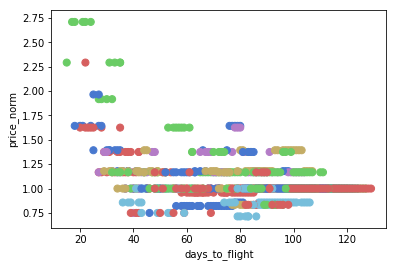

In [47]:
plot_days_to_flight_scatter(data[data['flight_number']==flights[i]], price='price_norm', color_map='departure_color')
i += 1

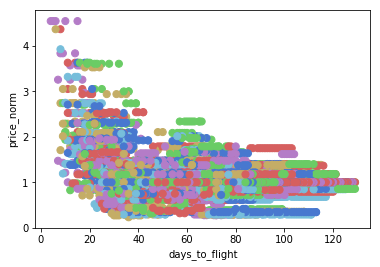

In [19]:
plot_days_to_flight_scatter(data, price='price_norm', color_map='departure_color')


## Price vs time to flight plots
Some data series seem to be wrong (e.g. i={15, 18, 27}) -- is this two separate flights merged? See plot below. What causes this bug.

In [154]:
departs = data['flight_id'].unique()
i = 0

In [260]:
price_col = 'price_gbp'
data2 = None
by_id = data.sort_values('days_to_flight', ascending=False)\
    .groupby('flight_id')
    
for flight_id, flights in by_id:
    previous_prices = np.roll(flights[price_col].values, 1)
    flight_data = flights[price_col] - previous_prices
    flight_data.values[0] = 1
    new_data = data[data['flight_id'] == flight_id].assign(price_change=flight_data)
    if data2 is None:
        data2 = new_data
    else:
        data2 = pd.concat([data2, new_data])
data = data2

/usr/local/lib/python3.4/dist-packages/matplotlib/cbook.py:2052: RuntimeWarning: invalid value encountered in double_scalars
  loval = q1 - whis * stats['iqr']
/usr/local/lib/python3.4/dist-packages/matplotlib/cbook.py:2053: RuntimeWarning: invalid value encountered in double_scalars
  hival = q3 + whis * stats['iqr']
/usr/local/lib/python3.4/dist-packages/matplotlib/cbook.py:2066: RuntimeWarning: invalid value encountered in less_equal
  wiskhi = np.compress(x <= hival, x)
/usr/local/lib/python3.4/dist-packages/matplotlib/cbook.py:2073: RuntimeWarning: invalid value encountered in greater_equal
  wisklo = np.compress(x >= loval, x)


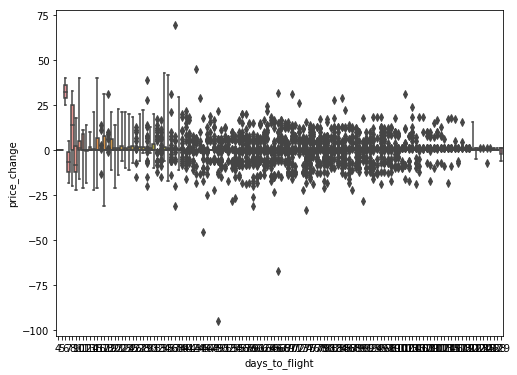

In [265]:
var_ctrl = 'days_to_flight'
var_dep = 'price_change'
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x=var_ctrl, y=var_dep, data=data, whis=np.inf)

/usr/local/lib/python3.4/dist-packages/ipykernel_launcher.py:14: FutureWarning: pd.rolling_mean is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.rolling(min_periods=10,center=False,window=15).mean()
  


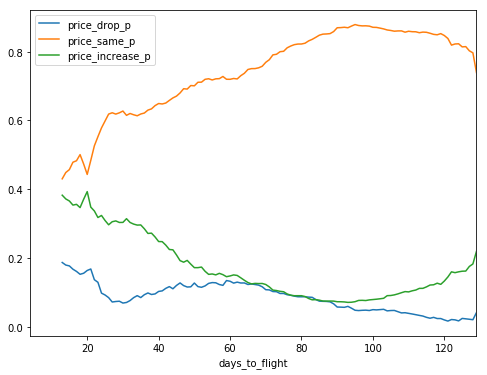

In [292]:
price_col = 'price_gbp'
price_drops = pd.DataFrame({'days_to_flight': [], 'price_drop_p': [], 'price_same_p': [], 'price_increase_p': []})
by_days = data.groupby('days_to_flight')
for days, flights in by_days:
    flight_data = flights['price_change']
    price_drops = price_drops.append({
        'days_to_flight': days,
        'price_drop_p': np.sum(flight_data.values < 0) / len(flight_data.values),
        'price_same_p': np.sum(flight_data.values == 0) / len(flight_data.values),
        'price_increase_p': np.sum(flight_data.values > 0) / len(flight_data.values),
    },
        ignore_index=True)
f, ax = plt.subplots(figsize=(8, 6))
means = pd.rolling_mean(price_drops[['price_drop_p', 'price_same_p', 'price_increase_p']], 15, min_periods=10)
means['days_to_flight'] = price_drops['days_to_flight']
# plt.plot(x=price_drops['days_to_flight'].values, y=means['price_drop_p'].values)
# plt.plot(x=price_drops['days_to_flight'].values, y=means['price_same_p'].values)
# plt.plot(x=price_drops['days_to_flight']values, y=means['price_increase_p'].values)
means.plot(x='days_to_flight', ax=ax)

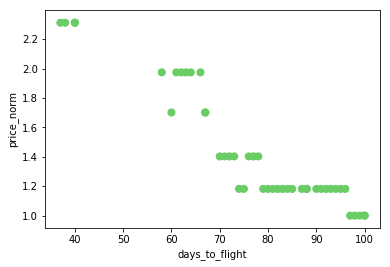

In [184]:

plot_days_to_flight_scatter(data[data['flight_id'] == departs[i]], price='price_norm', color_map='departure_color')
i += 1

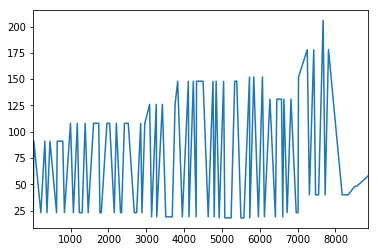

In [33]:
data[data['departure_time'] == departs[15]]['price'].plot()
# what's this? :O Two flights?

In [117]:
data[data['departure_time'] == departs[15]]

,Unnamed: 0,check_date,from,to,flight_date,departure_time,arrival_time,flight_number,price,price_gbp,timestamp_ms,days_to_flight,price_init,price_offset,price_norm,log_price_norm,flight_color,departure_color
15,131,2015-07-20 14:00:01.250,STN,POZ,2015-10-30,2015-10-30 11:20:00,2015-10-30 14:20,FR2336,22.99,22.9900,1.437401e+12,101,65.5128,-42.5228,0.350924,-1.047186,"(0.41568627450980394, 0.8, 0.396078431372549)","(0.7058823529411765, 0.48627450980392156, 0.78..."
28,99,2015-07-20 14:00:01.250,AGP,EDI,2015-10-30,2015-10-30 11:20:00,2015-10-30 13:45,FR6653,90.99,65.5128,1.437401e+12,101,65.5128,0.0000,1.000000,0.000000,"(0.8392156862745098, 0.37254901960784315, 0.37...","(0.7058823529411765, 0.48627450980392156, 0.78..."
214,102,2015-07-21 09:00:01.385,STN,POZ,2015-10-30,2015-10-30 11:20:00,2015-10-30 14:20,FR2336,22.99,22.9900,1.437469e+12,101,65.5128,-42.5228,0.350924,-1.047186,"(0.41568627450980394, 0.8, 0.396078431372549)","(0.7058823529411765, 0.48627450980392156, 0.78..."
320,70,2015-07-21 09:00:01.385,AGP,EDI,2015-10-30,2015-10-30 11:20:00,2015-10-30 13:45,FR6653,90.99,65.5128,1.437469e+12,101,65.5128,0.0000,1.000000,0.000000,"(0.8392156862745098, 0.37254901960784315, 0.37...","(0.7058823529411765, 0.48627450980392156, 0.78..."
375,131,2015-07-22 09:00:02.012,STN,POZ,2015-10-30,2015-10-30 11:20:00,2015-10-30 14:20,FR2336,22.99,22.9900,1.437556e+12,100,65.5128,-42.5228,0.350924,-1.047186,"(0.41568627450980394, 0.8, 0.396078431372549)","(0.7058823529411765, 0.48627450980392156, 0.78..."
455,27,2015-07-22 09:00:02.012,AGP,EDI,2015-10-30,2015-10-30 11:20:00,2015-10-30 13:45,FR6653,90.99,65.5128,1.437556e+12,100,65.5128,0.0000,1.000000,0.000000,"(0.8392156862745098, 0.37254901960784315, 0.37...","(0.7058823529411765, 0.48627450980392156, 0.78..."
629,131,2015-07-23 11:00:01.884,STN,POZ,2015-10-30,2015-10-30 11:20:00,2015-10-30 14:20,FR2336,22.99,22.9900,1.437649e+12,99,65.5128,-42.5228,0.350924,-1.047186,"(0.41568627450980394, 0.8, 0.396078431372549)","(0.7058823529411765, 0.48627450980392156, 0.78..."
646,34,2015-07-23 11:00:01.884,AGP,EDI,2015-10-30,2015-10-30 11:20:00,2015-10-30 13:45,FR6653,90.99,65.5128,1.437649e+12,99,65.5128,0.0000,1.000000,0.000000,"(0.8392156862745098, 0.37254901960784315, 0.37...","(0.7058823529411765, 0.48627450980392156, 0.78..."
793,63,2015-07-24 11:00:01.581,AGP,EDI,2015-10-30,2015-10-30 11:20:00,2015-10-30 13:45,FR6653,90.99,65.5128,1.437736e+12,98,65.5128,0.0000,1.000000,0.000000,"(0.8392156862745098, 0.37254901960784315, 0.37...","(0.7058823529411765, 0.48627450980392156, 0.78..."
837,131,2015-07-24 11:00:01.581,STN,POZ,2015-10-30,2015-10-30 11:20:00,2015-10-30 14:20,FR2336,22.99,22.9900,1.437736e+12,98,65.5128,-42.5228,0.350924,-1.047186,"(0.41568627450980394, 0.8, 0.396078431372549)","(0.7058823529411765, 0.48627450980392156, 0.78..."


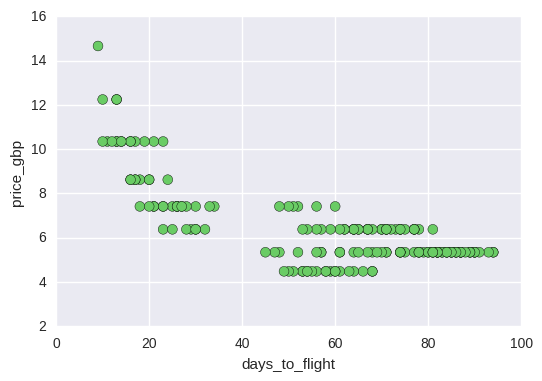

In [247]:
plot_days_to_flight_scatter(data[data['flight_number'] == 'FR6619'])

## Check this out!
Before we apply offset/normalisation to prices flight number or city tell us a lot about the price:

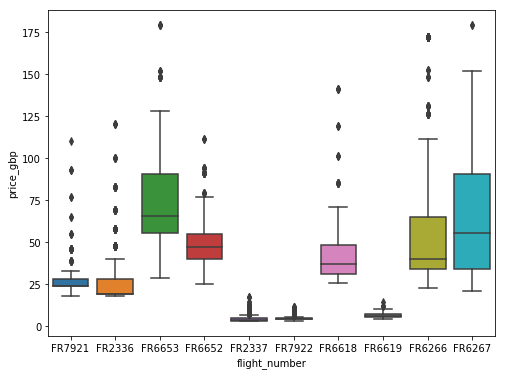

In [40]:
var_ctrl = 'flight_number'
var_dep = 'price_gbp'
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x=var_ctrl, y=var_dep, data=data)

However, after we apply the correction, there is little to extract from those variables:

In [115]:
# f = data['flight_number'].unique()
data[data['flight_number'] == 'FR7922']

,Unnamed: 0,check_date,from,to,flight_date,departure_time,arrival_time,flight_number,price,price_gbp,timestamp_ms,days_to_flight,price_init,price_offset,price_norm,log_price_norm,flight_color,departure_color
91,25,2015-07-20 14:00:01.250,GDN,EDI,2015-11-19,2015-11-19 20:30:00,2015-11-19 22:00,FR7922,23.99,4.138275,1.437401e+12,122,4.138275,0.0000,1.000000,0.000000,"(0.4666666666666667, 0.7450980392156863, 0.858...","(0.4666666666666667, 0.7450980392156863, 0.858..."
92,26,2015-07-20 14:00:01.250,GDN,EDI,2015-11-21,2015-11-21 14:45:00,2015-11-21 16:15,FR7922,23.99,4.138275,1.437401e+12,124,4.138275,0.0000,1.000000,0.000000,"(0.4666666666666667, 0.7450980392156863, 0.858...","(0.2823529411764706, 0.47058823529411764, 0.81..."
93,27,2015-07-20 14:00:01.250,GDN,EDI,2015-11-24,2015-11-24 14:45:00,2015-11-24 16:15,FR7922,23.99,4.138275,1.437401e+12,127,4.138275,0.0000,1.000000,0.000000,"(0.4666666666666667, 0.7450980392156863, 0.858...","(0.41568627450980394, 0.8, 0.396078431372549)"
94,28,2015-07-20 14:00:01.250,GDN,EDI,2015-11-26,2015-11-26 20:30:00,2015-11-26 22:00,FR7922,23.99,4.138275,1.437401e+12,129,4.138275,0.0000,1.000000,0.000000,"(0.4666666666666667, 0.7450980392156863, 0.858...","(0.8392156862745098, 0.37254901960784315, 0.37..."
110,24,2015-07-20 14:00:01.250,GDN,EDI,2015-11-17,2015-11-17 14:45:00,2015-11-17 16:15,FR7922,23.99,4.138275,1.437401e+12,120,4.138275,0.0000,1.000000,0.000000,"(0.4666666666666667, 0.7450980392156863, 0.858...","(0.8392156862745098, 0.37254901960784315, 0.37..."
112,23,2015-07-20 14:00:01.250,GDN,EDI,2015-11-14,2015-11-14 14:45:00,2015-11-14 16:15,FR7922,27.99,4.828275,1.437401e+12,117,4.828275,0.0000,1.000000,0.000000,"(0.4666666666666667, 0.7450980392156863, 0.858...","(0.4666666666666667, 0.7450980392156863, 0.858..."
113,21,2015-07-20 14:00:01.250,GDN,EDI,2015-11-10,2015-11-10 14:45:00,2015-11-10 16:15,FR7922,23.99,4.138275,1.437401e+12,113,4.138275,0.0000,1.000000,0.000000,"(0.4666666666666667, 0.7450980392156863, 0.858...","(0.41568627450980394, 0.8, 0.396078431372549)"
126,14,2015-07-20 14:00:01.250,GDN,EDI,2015-10-24,2015-10-24 14:45:00,2015-10-24 16:10,FR7922,23.99,4.138275,1.437401e+12,96,4.138275,0.0000,1.000000,0.000000,"(0.4666666666666667, 0.7450980392156863, 0.858...","(0.41568627450980394, 0.8, 0.396078431372549)"
127,15,2015-07-20 14:00:01.250,GDN,EDI,2015-10-27,2015-10-27 14:45:00,2015-10-27 16:15,FR7922,27.99,4.828275,1.437401e+12,99,4.828275,0.0000,1.000000,0.000000,"(0.4666666666666667, 0.7450980392156863, 0.858...","(0.2823529411764706, 0.47058823529411764, 0.81..."
128,16,2015-07-20 14:00:01.250,GDN,EDI,2015-10-29,2015-10-29 20:30:00,2015-10-29 22:00,FR7922,23.99,4.138275,1.437401e+12,101,4.138275,0.0000,1.000000,0.000000,"(0.4666666666666667, 0.7450980392156863, 0.858...","(0.8392156862745098, 0.37254901960784315, 0.37..."


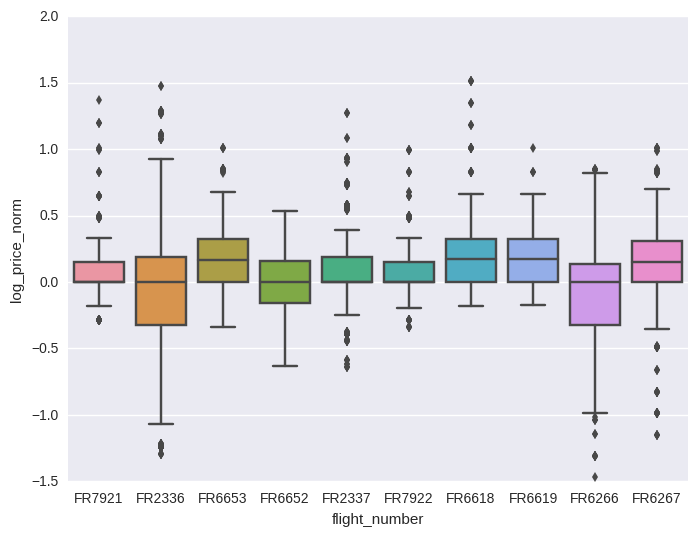

In [368]:
# var_ctrl = 'from'
var_ctrl = 'flight_number'
var_dep = 'log_price_norm'
# var_dep = 'price_norm'
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x=var_ctrl, y=var_dep, data=data)

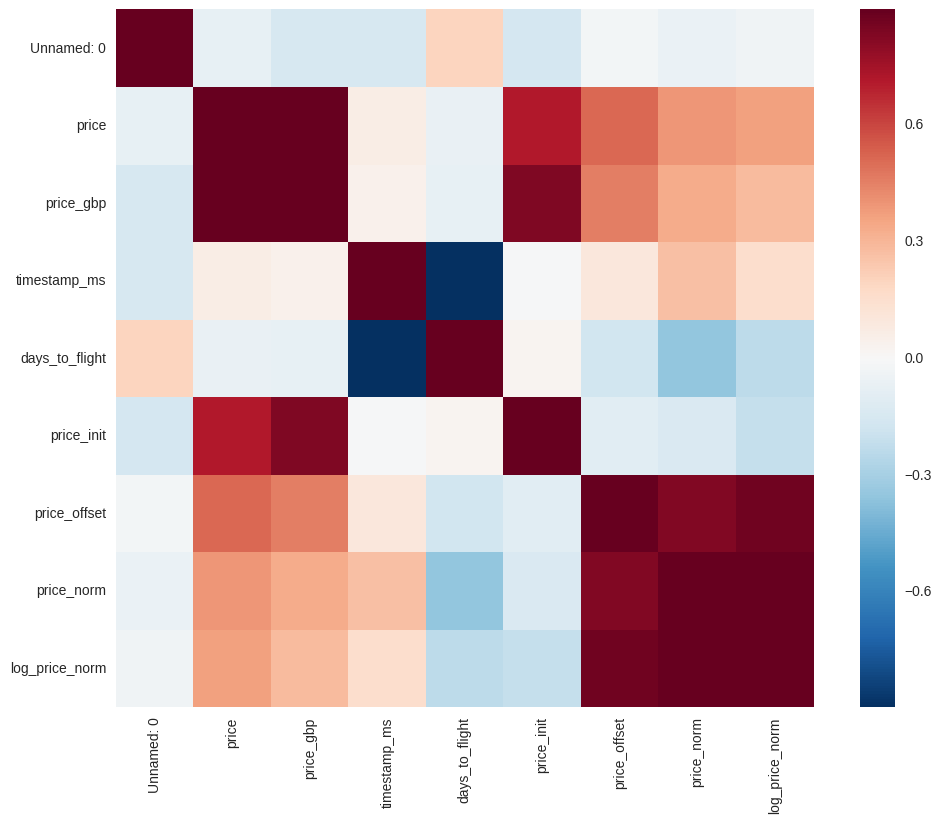

In [290]:
#correlation matrix
corrmat = data.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True);

# for completeness but obviously nothing interesting here

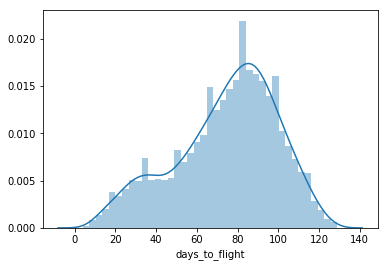

In [119]:
#histogram and normal probability plot
sns.distplot(data['days_to_flight']);
fig = plt.figure()

## Time series analysis of prices
How much spread is there around the mean price?

/usr/local/lib/python3.4/dist-packages/ipykernel_launcher.py:3: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(center=False,window=10).mean()
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.4/dist-packages/ipykernel_launcher.py:4: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(center=False,window=10).mean()
  after removing the cwd from sys.path.


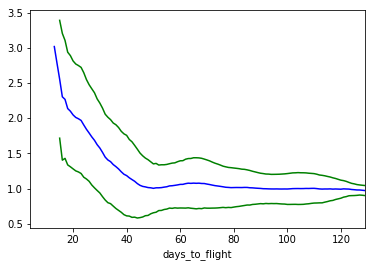

In [120]:
days_group = data.groupby('days_to_flight')
# rolling average added for smoother plot
means = pd.rolling_mean(days_group['price_norm'].mean(), 10)
bars = pd.rolling_mean(np.sqrt(days_group['price_norm'].var()), 10)

means.plot(c='b')
(means + bars).plot(c='g')
(means - bars).plot(c='g')

Naive bars -- assume that price spread is Gaussian -- untrue. See below how skew of the distribution differs after log transformation. Actually, price_norm is very close to 0, i.e. Gaussian is a good approximation.
https://en.wikipedia.org/wiki/Skewness

/usr/local/lib/python3.4/dist-packages/ipykernel_launcher.py:1: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(center=False,window=15).mean()
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.4/dist-packages/ipykernel_launcher.py:2: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(center=False,window=15).mean()
  
/usr/local/lib/python3.4/dist-packages/ipykernel_launcher.py:3: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(center=False,window=15).mean()
  This is separate from the ipykernel package so we can avoid doing imports until


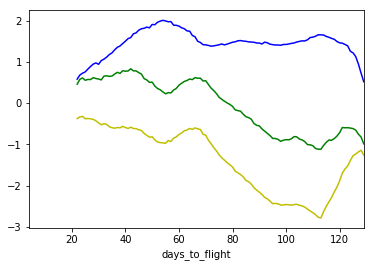

In [122]:
pd.rolling_mean(days_group['log_price_norm'].skew(), 15).plot(c='y')
pd.rolling_mean(days_group['price_norm'].skew(), 15).plot(c='g')
pd.rolling_mean(days_group['price_gbp'].skew(), 15).plot(c='b')

Box plot below tells the same story, the distribution is fairly symmetric. Compare to what the distribution looks like for unnormalised price_gbp

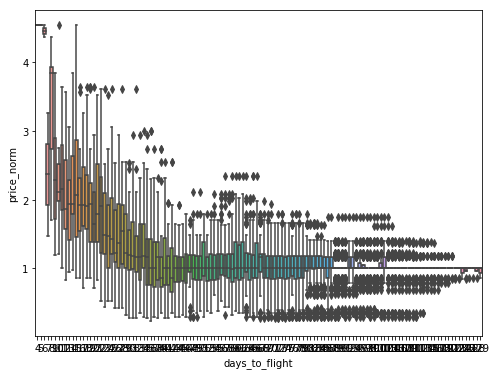

In [127]:
var_ctrl = 'days_to_flight'
var_dep = 'price_norm'
# var_dep = 'price_gbp'
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x=var_ctrl, y=var_dep, data=data)

**It seems price is not expected to increase (given only days_left) until 50 days to flight**

In [147]:
days_group.head()

,Unnamed: 0,check_date,from,to,flight_date,departure_time,arrival_time,flight_number,price,price_gbp,timestamp_ms,days_to_flight,price_init,price_offset,price_norm,log_price_norm,flight_color,departure_color
0,1,2015-07-20 14:00:01.250,EDI,GDN,2015-10-20,2015-10-20 16:35:00,2015-10-20 19:55,FR7921,23.99,23.990000,1.437401e+12,92,23.990000,0.0000,1.000000,0.000000,"(0.2823529411764706, 0.47058823529411764, 0.81...","(0.2823529411764706, 0.47058823529411764, 0.81..."
1,117,2015-07-20 14:00:01.250,STN,POZ,2015-10-16,2015-10-16 11:20:00,2015-10-16 14:25,FR2336,33.99,33.990000,1.437401e+12,87,33.990000,0.0000,1.000000,0.000000,"(0.41568627450980394, 0.8, 0.396078431372549)","(0.41568627450980394, 0.8, 0.396078431372549)"
2,118,2015-07-20 14:00:01.250,STN,POZ,2015-10-17,2015-10-17 11:20:00,2015-10-17 14:25,FR2336,18.99,18.990000,1.437401e+12,88,18.990000,0.0000,1.000000,0.000000,"(0.41568627450980394, 0.8, 0.396078431372549)","(0.8392156862745098, 0.37254901960784315, 0.37..."
3,119,2015-07-20 14:00:01.250,STN,POZ,2015-10-18,2015-10-18 11:20:00,2015-10-18 14:25,FR2336,22.99,22.990000,1.437401e+12,89,22.990000,0.0000,1.000000,0.000000,"(0.41568627450980394, 0.8, 0.396078431372549)","(0.7058823529411765, 0.48627450980392156, 0.78..."
4,120,2015-07-20 14:00:01.250,STN,POZ,2015-10-19,2015-10-19 11:20:00,2015-10-19 14:25,FR2336,18.99,18.990000,1.437401e+12,90,18.990000,0.0000,1.000000,0.000000,"(0.41568627450980394, 0.8, 0.396078431372549)","(0.7686274509803922, 0.6784313725490196, 0.4)"
5,121,2015-07-20 14:00:01.250,STN,POZ,2015-10-20,2015-10-20 11:20:00,2015-10-20 14:25,FR2336,18.99,18.990000,1.437401e+12,91,18.990000,0.0000,1.000000,0.000000,"(0.41568627450980394, 0.8, 0.396078431372549)","(0.4666666666666667, 0.7450980392156863, 0.858..."
6,122,2015-07-20 14:00:01.250,STN,POZ,2015-10-21,2015-10-21 11:20:00,2015-10-21 14:25,FR2336,18.99,18.990000,1.437401e+12,92,18.990000,0.0000,1.000000,0.000000,"(0.41568627450980394, 0.8, 0.396078431372549)","(0.2823529411764706, 0.47058823529411764, 0.81..."
7,123,2015-07-20 14:00:01.250,STN,POZ,2015-10-22,2015-10-22 11:20:00,2015-10-22 14:25,FR2336,18.99,18.990000,1.437401e+12,93,18.990000,0.0000,1.000000,0.000000,"(0.41568627450980394, 0.8, 0.396078431372549)","(0.41568627450980394, 0.8, 0.396078431372549)"
8,124,2015-07-20 14:00:01.250,STN,POZ,2015-10-23,2015-10-23 11:20:00,2015-10-23 14:25,FR2336,33.99,33.990000,1.437401e+12,94,33.990000,0.0000,1.000000,0.000000,"(0.41568627450980394, 0.8, 0.396078431372549)","(0.8392156862745098, 0.37254901960784315, 0.37..."
9,116,2015-07-20 14:00:01.250,STN,POZ,2015-10-15,2015-10-15 11:20:00,2015-10-15 14:25,FR2336,27.99,27.990000,1.437401e+12,86,27.990000,0.0000,1.000000,0.000000,"(0.41568627450980394, 0.8, 0.396078431372549)","(0.7058823529411765, 0.48627450980392156, 0.78..."


# Conclusions

1. If you have to buy a particular ticket, buy it now - price is always expected to increase with time for a given ticket
2. Prices are relatively stable until ~40 days before the flight
3. Normalization that made the distribution of prices most similar to Gaussian was $\frac{p}{p_{init}}$
4. Likelihood of price drop starts to increase ~25 days before flight